In [1]:
import pandas as pd
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import DataLoader
from time import time
import matplotlib.pyplot as plt

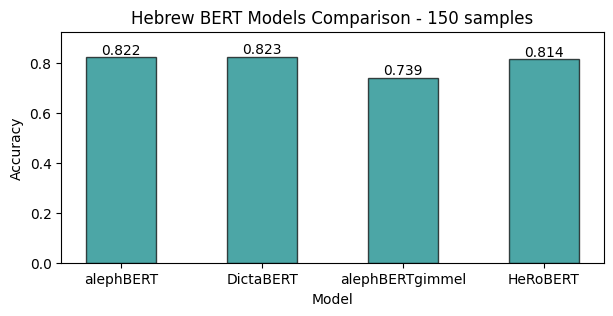

In [2]:
alephBERT_accuracies = [0.828, 0.832, 0.829, 0.822, 0.806, 0.816] # ran pipeline on different configurations
DictaBERT_accuracies = [0.812, 0.834, 0.818, 0.824, 0.827, 0.825]
alephBERTgimmel_accuracies = [0.736, 0.748, 0.721, 0.739, 0.752]
HeRoBERT_accuracies = [0.827, 0.778, 0.833, 0.809, 0.813, 0.823]

def bar_plot(values, names, title, x_label, y_label, color):
    plt.figure(figsize=(7, 3))
    plt.bar(names, values, color=color, alpha=0.7, edgecolor='black', width=0.5)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.ylim(0, max(values) + 0.1)
    for i, value in enumerate(values):
        plt.text(i, value, str(round(value, 3)), ha='center', va='bottom')
    plt.show()

accuracies = [np.mean(alephBERT_accuracies), np.mean(DictaBERT_accuracies), np.mean(alephBERTgimmel_accuracies), np.mean(HeRoBERT_accuracies)]
names = ['alephBERT', 'DictaBERT', 'alephBERTgimmel', 'HeRoBERT']
title = 'Hebrew BERT Models Comparison - 150 samples'
x_label = 'Model'
y_label = 'Accuracy'
color = 'teal'

bar_plot(accuracies, names, title, x_label, y_label, color)

In [10]:
# grid search results 
results_path = '/home/munz/school/research_methods/results2.csv'
results = pd.read_csv(results_path)

results = results.sort_values(by='accuracy', ascending=False)
results.head(10)

,search,epoch,batch_size,learning_rate,accuracy
5,14,5,32,0.00005,0.848047
17,19,7,16,0.00003,0.846094
12,2,3,16,0.00005,0.846094
11,23,7,32,0.00005,0.844141
2,9,5,16,0.00002,0.842969
9,22,7,32,0.00003,0.841797
3,10,5,16,0.00003,0.841797
6,13,5,32,0.00003,0.841016
16,11,5,16,0.00005,0.839063
18,11,5,16,0.00005,0.839063


In [3]:
increasing_train_path = r'/home/munz/school/research_methods/increasing_train_results.csv'
increasing_train_df = pd.read_csv(increasing_train_path)
increasing_train_df.head(11)

,num_batches,accuracy,time,train_samples
0,0,0.8414,00:26.12,150
1,1,0.8691,01:26.11,1150
2,2,0.8750,02:25.45,2150
3,3,0.8918,03:25.29,3150
4,4,0.8973,04:25.89,4150
5,5,0.9016,05:49.77,5150
6,6,0.9094,07:02.74,6150
7,7,0.9277,07:57.94,7150
8,8,0.9313,09:14.15,8150
9,9,0.9364,10:18.89,9150


In [81]:
results_path = '/home/munz/school/research_methods/results.csv'
results = pd.read_csv(results_path)
results.head(40)

,data,num_batches,accuracy,time_elapsed,train_size
0,s2s_translated,0,0.8414,00:26.74,150
1,s2s_translated,1,0.7113,01:26.27,1150
2,s2s_translated,2,0.7109,02:25.89,2150
3,s2s_translated,3,0.6453,03:25.36,3150
4,s2s_translated,4,0.6504,04:25.44,4150
5,s2s_translated,5,0.6687,04:44.59,4487
6,transformer_translated,0,0.8414,00:25.95,150
7,transformer_translated,1,0.7832,01:25.54,1150
8,transformer_translated,2,0.6262,02:25.23,2150
9,transformer_translated,3,0.7070,03:25.09,3150


In [73]:
def plot_data(xs, ys, colors, names, title, x_label, y_label):
    plt.figure(figsize=(10, 3))
    for x, y, color, name in zip(xs, ys, colors, names):
        plt.plot(x, y, color=color, marker='o', label=name)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

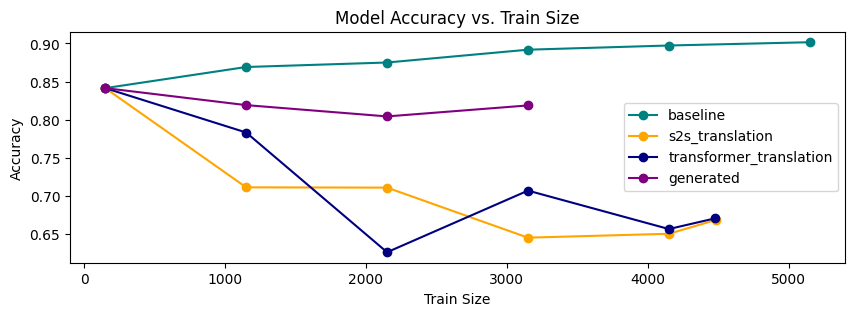

In [77]:
baseline_x = increasing_train_df['train_samples'].values[:6]
baseline_y = increasing_train_df['accuracy'].values[:6]
s2s_x = results[results['data'] == 's2s_translated']['train_size'].values
s2s_y = results[results['data'] == 's2s_translated']['accuracy'].values
transformer_x = results[results['data'] == 'transformer_translated']['train_size'].values
transformer_y = results[results['data'] == 'transformer_translated']['accuracy'].values
generated_x = results[results['data'] == 'generated']['train_size'].values
generated_y = results[results['data'] == 'generated']['accuracy'].values

xs = [baseline_x, s2s_x, transformer_x, generated_x]

ys = [baseline_y, s2s_y, transformer_y, generated_y]

colors = ['teal', 'orange', 'navy', 'purple']
names = ['baseline', 's2s_translation', 'transformer_translation', 'generated']
title = 'Model Accuracy vs. Train Size'
x_label = 'Train Size'
y_label = 'Accuracy'

plot_data(xs, ys, colors, names, title, x_label, y_label)

In [ ]:
values = [0.828, 0.832, 0.829, 0.822, 0.806, 0.816]
names = ['baseline', 'seq2seq translation', 'transformer translation', 'generated', 'transformer + generated']
title = 'Model Accuracy'
x_label = 'Model'
y_label = 'Accuracy'
color = 'teal'

bar_plot(values, names, title, x_label, y_label, color):